In [1]:
import os, sys, subprocess, pickle, toml
import numpy as np
import pandas as pd
import xarray as xr
import pickle
import matplotlib.pyplot as plt

# import MO-ASMO functions
# path_MOASMO = '/glade/u/home/guoqiang/model_sources/MO-ASMO/src'
path_MOASMO = '/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src/'
sys.path.append(path_MOASMO)
import sampling
import gp
import NSGA2

sys.path.append('../MOASMO_support/')
from MOASMO_parameters import *
import run_multiple_paramsets_Derecho

In [2]:
target = 1

In [3]:
# evaluation results
file_metric_all = []
file_param_all = []
iter_end = 1
num_init = 400
num_per_iter = 20
path_archive = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{target}_MOASMOcalib/ctsm_outputs'

for it in range(0, iter_end):
    print('#'*50)
    print(f'Start iterattion {it}')
    

    iterflag = it

    if it == 0:
        sample_num = num_init
    else:
        sample_num = num_per_iter

    file_metric_iter, file_param_iter = run_multiple_paramsets_Derecho.check_if_all_runs_are_finsihed(path_archive, iterflag, sample_num)
    file_metric_all.append(file_metric_iter)
    file_param_all.append(file_param_iter)


##################################################
Start iterattion 0


In [4]:
# param_filelist = ['/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO/level1_0_MOASMOcalib/ctsm_outputs/iter0_all_meanparam.csv']
# metric_filelist = ['/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO/level1_0_MOASMOcalib/ctsm_outputs/iter0_all_metric.csv']
# param_infofile = '/glade/work/guoqiang/CTSM_CAMELS/data_paramcailb/ParamCalib_1013500.csv'


param_filelist = file_param_all
metric_filelist = file_metric_all

configfile = f'/glade/work/guoqiang/CTSM_CAMELS/Calib_HH_MOASMO/configuration/_level1-{target}_config_MOASMO.toml'
config = toml.load(configfile)
param_infofile = config['file_calib_param']

outpath = '/glade/derecho/scratch/guoqiang'

iterflag = 0

In [5]:
# define parameters and load data

# define hyper parameters
pop = 100
gen = 100
crossover_rate = 0.9
mu = 20
mum = 20

# define hyperparameter
alpha = 1e-3
leng_lb = 1e-3
leng_ub = 1e3
nu = 2.5

n_sample = 20 # number of selected optimal points

# input data x (parameter sets) and output data y (objective function values)
df_param = pd.concat(map(pd.read_csv, param_filelist))
df_metric = pd.concat(map(pd.read_csv, metric_filelist))
df_info = read_parameter_csv(param_infofile)

param_names = df_info['Parameter'].values # exclude binded parameters
df_param = df_param[param_names]

xlb_mean = np.array([np.nanmean(v) for v in df_info['Lower']])
xub_mean = np.array([np.nanmean(v) for v in df_info['Upper']])

x = df_param.to_numpy()
y = df_metric.to_numpy()

ind = ~np.isnan( np.sum(x,axis=1) + np.sum(y,axis=1))
x, y = x[ind, :], y[ind, :]

nInput = x.shape[1]
nOutput = y.shape[1]

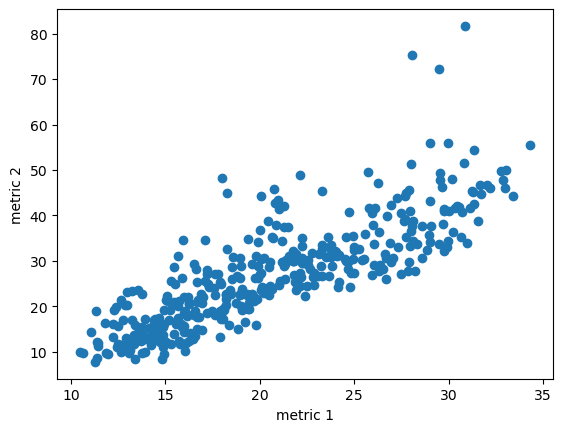

In [6]:
# plot 2 metrics from the iterations

plt.scatter(y[:,0], y[:,1])
plt.xlabel('metric 1')
plt.ylabel('metric 2')
plt.show()

metric-1 train cc 0.9999999976826337
metric-1 train cc 0.9053193864085002
metric-2 train cc 0.9999999999265672
metric-2 test cc 0.753841133027863


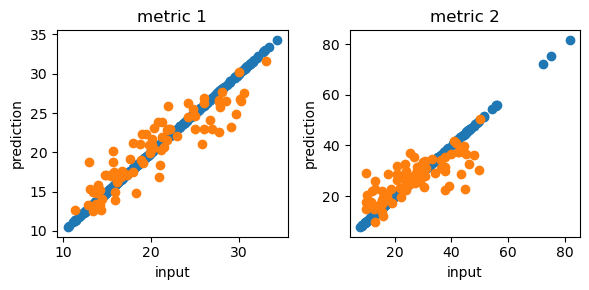

In [7]:
# MO-ASMO GPR

yin = y.copy()
xin = x.copy()

index_train = np.random.choice(np.arange(xin.shape[0]), size=int(0.8 * xin.shape[0]), replace=False)
index_test = np.setdiff1d(np.arange(xin.shape[0]), index_train)


# for i in range(xin.shape[0]):
#     xin[i, :] = (xin[i, :] - xlb_mean) / (xub_mean - xlb_mean)

# for i in range(2):
#     yin[:,i] = (yin[:,i] - np.nanmin(yin[:,i])) / (np.nanmax(yin[:,i]) - np.nanmin(yin[:,i]))

sm = gp.GPR_Matern(xin[index_train,:], yin[index_train,:], nInput, nOutput, N=len(index_train), xlb=xlb_mean, xub=xub_mean, alpha=alpha, leng_sb=[leng_lb, leng_ub], nu=nu)

# check surrogate model results
y_predict = sm.predict(xin)

fig = plt.figure(figsize=[6, 3])

fig.add_subplot(1,2,1)
plt.scatter(yin[index_train,0], y_predict[index_train,0])
plt.scatter(yin[index_test,0], y_predict[index_test,0])
plt.title('metric 1')
plt.xlabel('input')
plt.ylabel('prediction')
print('metric-1 train cc', np.corrcoef(yin[index_train,0], y_predict[index_train,0])[0,1])
print('metric-1 train cc', np.corrcoef(yin[index_test,0], y_predict[index_test,0])[0,1])

fig.add_subplot(1,2,2)
plt.scatter(yin[index_train,1], y_predict[index_train,1])
plt.scatter(yin[index_test,1], y_predict[index_test,1])
plt.title('metric 2')
plt.xlabel('input')
plt.ylabel('prediction')
print('metric-2 train cc', np.corrcoef(yin[index_train,1], y_predict[index_train,1])[0,1])
print('metric-2 test cc', np.corrcoef(yin[index_test,1], y_predict[index_test,1])[0,1])

plt.tight_layout()
plt.show()


metric-1 train cc 0.9895412724145335
metric-1 train cc 0.9044630532355178
metric-2 train cc 0.9836752189057016
metric-2 test cc 0.7811082946958535


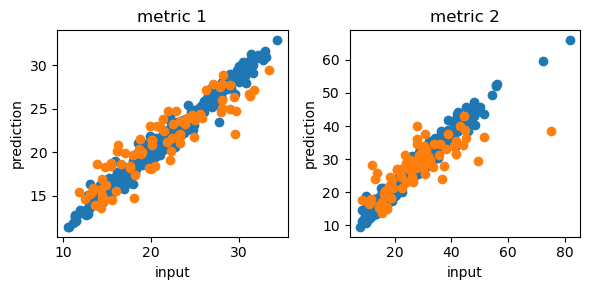

In [23]:
# Sklearn RF
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
yin = y.copy()
xin = x.copy()

# # normalize yin
# for i in range(yin.shape[1]):
#     yin[:,i] = (yin[:,i] - min(yin[:,i])) / (max(yin[:,i]) - min(yin[:,i]))

index_train = np.random.choice(np.arange(xin.shape[0]), size=int(0.8 * xin.shape[0]), replace=False)
index_test = np.setdiff1d(np.arange(xin.shape[0]), index_train)

sm_rf = RandomForestRegressor()
sm_rf.fit(xin[index_train,:], yin[index_train,:])

# check surrogate model results
y_predict = sm_rf.predict(xin)

fig = plt.figure(figsize=[6, 3])

fig.add_subplot(1,2,1)
plt.scatter(yin[index_train,0], y_predict[index_train,0])
plt.scatter(yin[index_test,0], y_predict[index_test,0])
plt.title('metric 1')
plt.xlabel('input')
plt.ylabel('prediction')
print('metric-1 train cc', np.corrcoef(yin[index_train,0], y_predict[index_train,0])[0,1])
print('metric-1 train cc', np.corrcoef(yin[index_test,0], y_predict[index_test,0])[0,1])

fig.add_subplot(1,2,2)
plt.scatter(yin[index_train,1], y_predict[index_train,1])
plt.scatter(yin[index_test,1], y_predict[index_test,1])
plt.title('metric 2')
plt.xlabel('input')
plt.ylabel('prediction')
print('metric-2 train cc', np.corrcoef(yin[index_train,1], y_predict[index_train,1])[0,1])
print('metric-2 test cc', np.corrcoef(yin[index_test,1], y_predict[index_test,1])[0,1])

plt.tight_layout()
plt.show()

In [35]:
print(xin.shape, yin.shape)

(400, 17) (400, 2)


/glade/u/apps/opt/conda/envs/npl-2022b/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2022b/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 11 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2022b/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 12 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


metric-1 train cc 0.9999999999999993
metric-1 train cc 0.9667673214944148
metric-2 train cc 1.0
metric-2 test cc 0.9468039715193404


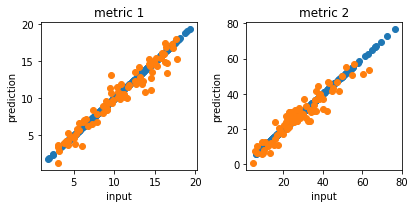

In [40]:
# Sklearn GPR

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
import numpy as np
import matplotlib.pyplot as plt

# Assuming xin, yin are your input and output datasets
yin = y.copy()
# yin = np.random.uniform(size=y.shape)
xin = x.copy()
# xin = np.random.uniform(size=x.shape)


index_train = np.random.choice(np.arange(xin.shape[0]), size=int(0.8 * xin.shape[0]), replace=False)
index_test = np.setdiff1d(np.arange(xin.shape[0]), index_train)

# Define the kernel with Matern
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(xin.shape[1]), length_scale_bounds=(1e-3, 1e3), nu=1.5)

sm_skgpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
sm_skgpr.fit(xin[index_train,:], yin[index_train,:])

# check surrogate model results
y_predict = sm_skgpr.predict(xin)

fig = plt.figure(figsize=[6, 3])

fig.add_subplot(1,2,1)
plt.scatter(yin[index_train,0], y_predict[index_train,0])
plt.scatter(yin[index_test,0], y_predict[index_test,0])
plt.title('metric 1')
plt.xlabel('input')
plt.ylabel('prediction')
print('metric-1 train cc', np.corrcoef(yin[index_train,0], y_predict[index_train,0])[0,1])
print('metric-1 train cc', np.corrcoef(yin[index_test,0], y_predict[index_test,0])[0,1])

fig.add_subplot(1,2,2)
plt.scatter(yin[index_train,1], y_predict[index_train,1])
plt.scatter(yin[index_test,1], y_predict[index_test,1])
plt.title('metric 2')
plt.xlabel('input')
plt.ylabel('prediction')
print('metric-2 train cc', np.corrcoef(yin[index_train,1], y_predict[index_train,1])[0,1])
print('metric-2 test cc', np.corrcoef(yin[index_test,1], y_predict[index_test,1])[0,1])

plt.tight_layout()
plt.show()

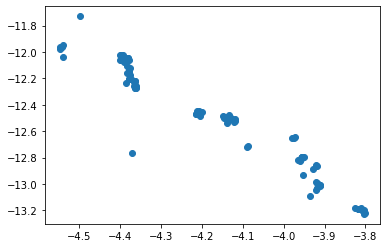

In [24]:
# perform optimization using the surrogate model: MO-ASMO GPR
bestx_sm, besty_sm, x_sm, y_sm = NSGA2.optimization(sm, nInput, nOutput, xlb_mean, xub_mean, pop, gen, crossover_rate, mu, mum)
D = NSGA2.crowding_distance(besty_sm)
idxr = D.argsort()[::-1][:n_sample]
x_resample = bestx_sm[idxr, :]
y_resample = besty_sm[idxr, :]
# y_resample = sm.predict(x_resample)

# plot
plt.scatter(besty_sm[:, 0], besty_sm[:, 1])

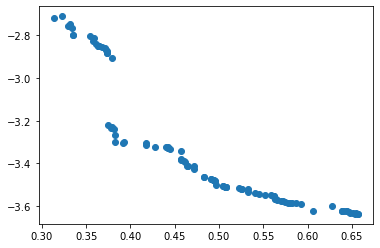

In [25]:
# perform optimization using the surrogate model: sklearn GPR
bestx_sm, besty_sm, x_sm, y_sm = NSGA2.optimization(sm_skgpr, nInput, nOutput, xlb_mean, xub_mean, pop, gen, crossover_rate, mu, mum)
D = NSGA2.crowding_distance(besty_sm)
idxr = D.argsort()[::-1][:n_sample]
x_resample = bestx_sm[idxr, :]
y_resample = besty_sm[idxr, :]
# y_resample = sm.predict(x_resample)

# plot
plt.scatter(besty_sm[:, 0], besty_sm[:, 1])

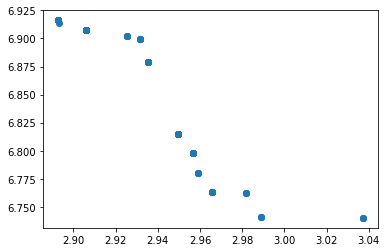

In [26]:
# perform optimization using the surrogate model: RF
bestx_sm, besty_sm, x_sm, y_sm = NSGA2.optimization(sm_rf, nInput, nOutput, xlb_mean, xub_mean, pop, gen, crossover_rate, mu, mum)
D = NSGA2.crowding_distance(besty_sm)
idxr = D.argsort()[::-1][:n_sample]
x_resample = bestx_sm[idxr, :]
y_resample = besty_sm[idxr, :]
# y_resample = sm.predict(x_resample)

# plot
plt.scatter(besty_sm[:, 0], besty_sm[:, 1])